In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

In [2]:
# frame = 1290
# timeframe = 11301
# timesteps = [319, 320, 324, 321, 322, 323, 330, 326, 325, 327, 329, 328]
ignored_peds = [171, 216]
NUM_SAMPLES = 100
ALPHA = 1.0
H = 11

In [3]:
mat = np.loadtxt("/home/todor/Documents/datasets/eth/ewap_dataset/seq_eth/obsmat.txt")
_H = np.loadtxt("/home/todor/Documents/datasets/eth/ewap_dataset/seq_eth/H.txt")
Hinv = np.linalg.inv(_H)

In [4]:
num_frames = (mat[-1,0] + 1).astype("int")
num_times = np.unique(mat[:,0]).size
num_peds = int(np.max(mat[:,1])) + 1
frames = [-1] * num_frames # maps frame -> timestep
timeframes = [-1] * num_times # maps timestep -> (first) frame
timesteps = [[] for _ in range(num_times)] # maps timestep -> ped IDs
peds = [np.array([]).reshape(0,4) for _ in range(num_peds)] # maps ped ID -> (t,x,y,z) path
frame = 0
time = -1

In [5]:
print(mat.shape)
print(np.asarray(peds).shape)

(8908, 8)
(368, 0, 4)


In [6]:
for row in mat:
    if row[0] != frame:
        frame = int(row[0])
        time += 1
        frames[frame] = time
        timeframes[time] = frame
    ped = int(row[1])
    if ped not in ignored_peds: # TEMP HACK - can cause empty timesteps
        timesteps[time].append(ped)
    loc = np.array([row[2], row[4], 1])
    loc = np.dot(Hinv, loc) # to camera frame
    loc = loc/loc[2]
    loc = [time, loc[0], loc[1], loc[2]]
    peds[ped] = np.vstack((peds[ped], loc))

In [7]:
print(frames[11301])
print(timeframes[1290])
print(timesteps[1290])
print(peds[319])
print(np.asarray(peds).shape)

1290
11301
[319, 320, 324, 321, 322, 323, 330, 326, 325, 327, 329, 328]
[[  1.27400000e+03   3.75000010e+02   3.00000001e+02   1.00000000e+00]
 [  1.27500000e+03   3.66999991e+02   2.92999999e+02   1.00000000e+00]
 [  1.27600000e+03   3.51000001e+02   2.90000001e+02   1.00000000e+00]
 [  1.27700000e+03   3.45000001e+02   2.87000001e+02   1.00000000e+00]
 [  1.27800000e+03   3.35000000e+02   2.85000000e+02   1.00000000e+00]
 [  1.27900000e+03   3.26000000e+02   2.83000000e+02   1.00000000e+00]
 [  1.28000000e+03   3.16000001e+02   2.81000001e+02   1.00000000e+00]
 [  1.28100000e+03   3.07000000e+02   2.82000001e+02   1.00000000e+00]
 [  1.28200000e+03   2.97000001e+02   2.83000000e+02   1.00000000e+00]
 [  1.28300000e+03   2.86000000e+02   2.82999999e+02   1.00000000e+00]
 [  1.28400000e+03   2.73999999e+02   2.85000000e+02   1.00000000e+00]
 [  1.28500000e+03   2.63000001e+02   2.85000001e+02   1.00000000e+00]
 [  1.28600000e+03   2.52999999e+02   2.84000001e+02   1.00000000e+00]
 [  1

In [8]:
frame = frames[11301]
timeframe = timeframes[1290]
timestep = timesteps[1290]
agents = [peds[i] for i in timestep]

In [9]:
t = frame
last_t = t
agent_index = next((i for i,v in enumerate(timestep) if v==1), 0) # 1 or 0 - yes robot is 1 but if not put the first one as roobot
displayed_agent = timestep[agent_index]
past_paths = []
true_paths = []
prior = []

In [10]:
print(agent_index)
print(displayed_agent)
print(timestep)
print(timeframe)
print(frame)
print(np.asarray(agents[1]).shape)

0
319
[319, 320, 324, 321, 322, 323, 330, 326, 325, 327, 329, 328]
11301
1290
(35, 4)


In [11]:
def get_path_at_time(t, fullpath):
#     print(fullpath[:,0])
    path_end = next(i for i,v in enumerate(fullpath[:,0]) if v==t)
#     print(path_end)
    points = list(range(0,path_end+1))
#     print(points)
#     print(fullpath.shape)
    if path_end < fullpath.shape[0]:
        points += [-1] # Add the destination point.
    past_plus_dest = fullpath[np.ix_(points)]
    future = fullpath[path_end:]
    return past_plus_dest, future

In [12]:
def sq_exp(a, b, _, l, sigma2=1):
    return sigma2 * np.exp(-.5 * sq_dist(a/l, b/l))

def sq_dist(a, b):
    return (a**2).reshape(-1, 1) + b**2 - 2*np.outer(a, b)

def matern(a, b, kind, l, sigma2=1):
    if kind == 'test' and False:
        return sigma2
    else:
        a = np.sqrt(5) * a/l;
        b = np.sqrt(5) * b/l;
        r = sq_dist(a, b)
        return sigma2 * np.exp(-np.sqrt(r)) * (1 + np.sqrt(r) + r/3);

def linear(a, b, kind, sigma2=1):
    if kind == 'test' and False:
        r = np.sum((a*b).reshape(-1,1), 1).reshape(-1,1)
    else:
        r = np.outer(a, b)
    return (1 + r) * sigma2

def noise(a, b, kind, sigma2=0):
    if kind == 'train':
        return sigma2 * np.eye(len(a))
    elif kind == 'test':
        return sigma2
    else:
#       return sigma2
        return 0

def sq_exp_kernel(l=1, sigma2=1):
    ''' Squared exponential kernel. '''
    def f(a, b, kind):
        return sq_exp(a, b, kind, l, sigma2)
    return f

def matern_kernel(l, sigma2=1):
    '''
    Matérn kernel. See "Gaussian Processes for Machine Learning", by
    Rasmussen and Williams, Chapter 4.
    
    Specifically, this kernel is Matérn class with v=5/2, multiplied by an
    optional signal variance sigma2.
    '''
    def f(a, b, kind):
        return matern(a, b, kind, l, sigma2)
    return f

def linear_kernel(sigma2=1):
    ''' Linear kernel, obtained from linear regression. '''
    def f(a, b, kind):
        return linear(a, b, kind, sigma2)
    return f

def noise_kernel(sigma2=0):
    '''
    Standard noise kernel. Adds a small amount of variance at every point
    in the covariance matrix where i=j.
    '''
    def f(a, b, kind):
        return noise(a, b, kind, sigma2)
    return f

def summed_kernel(*args):
    '''
    Forms a kernel consisting of the sum of the given kernels.
    '''
    def f(a, b, kind):
        K = np.zeros((len(a), len(b)))
        for k in args:
            K += k(a, b, kind)
        return K
    return f

In [13]:
class GaussianProcess:
    '''
    Represents a Gaussian process that can be sampled from. Samples are taken
    at each test point, given the supplied observations.
    '''

    def __init__(self, zx, zy, testpoints, kernel=sq_exp_kernel()):
        ''' Creates a new Gaussian process from the given observations. '''
        self.timepoints = testpoints
        self.kernel = kernel
        
        # covariance of observations
        self.K = kernel(zx, zx, 'train')
        self.K += 1e-9*np.eye(self.K.shape[0])
        Ltrain = np.linalg.cholesky(self.K)
        
        # compute the predictive mean at our test points
        self.Kstar = kernel(zx, testpoints, 'cross')
        v = np.linalg.solve(Ltrain, self.Kstar)
        self.mu = np.dot(v.T, np.linalg.solve(Ltrain, zy))
        
        # compute the predictive variance at our test points
        self.Kss = kernel(testpoints, testpoints, 'test')
        self.Kss += 1e-9*np.eye(self.Kss.shape[0])
        self.prior_L = np.linalg.cholesky(self.Kss)
        
        self.Kss = self.kernel(testpoints, testpoints, 'train')
        self.L = np.linalg.cholesky(self.Kss - np.dot(v.T, v))
    
    def sample(self, n=1):
        '''
        Draw n samples from the gaussian process posterior.
        
        Returns a timepoints x n matrix, with each sample being a column.
        '''
        sz = (len(self.timepoints), n)
        return self.mu.reshape(-1,1) + np.dot(self.L, np.random.normal(size=sz))

In [14]:
def sample(xgp, ygp, n=1):
    x_post = xgp.sample(n)
    y_post = ygp.sample(n)
    
    return np.dstack((x_post, y_post))

In [15]:
def dist(loc1, loc2):
    return np.linalg.norm(loc2 - loc1)

def rbf(loc1, loc2):
    d = dist(loc1, loc2)
    return 1 - ALPHA*np.exp(-(d**2) / (2*H**2))

In [16]:
def interaction(allpriors):
    """
    The Interaction Potential, denoted as 'psi' in Trautman & Krause, 2010.
    """
    # Input has shape: [agent](time, samples, x/y)
    weights = np.ones(NUM_SAMPLES)
    for i in range(NUM_SAMPLES):
        num_agents = len(allpriors)
        for j in range(num_agents):
            agent_j = allpriors[j]
            for k in range(j+1, num_agents):
                agent_k = allpriors[k]
                for t in range(min(len(agent_j), len(agent_k))):
                    weights[i] *= rbf(agent_j[t,i], agent_k[t,i])
    # Renormalize
    total = np.sum(weights)
    if total == 0:
        # If there is no safe path, we would normally stop the robot. For now,
        # I'd rather choose the mean instead. Simulate this by weighting all
        # paths equally.
        print("WARNING: All paths weighted to 0.", file=sys.stderr)
        weights = np.ones(NUM_SAMPLES)
        total = NUM_SAMPLES
    weights /= total
    return weights

In [17]:
weights = interaction(prior)
sortdex = np.argsort(-weights)
weights = weights[sortdex]
prior = [p[:,sortdex,:] for p in prior]

In [28]:
for ped in timestep:#[319]:#
    idx = [i for i, a in enumerate(agents) if timestep[i]==ped]

    past_plus_dest, future = get_path_at_time(t, agents[idx[0]])
    past_paths.append(past_plus_dest[:-1, 1:]) # first col is time, row is goal
    true_paths.append(future[:, 1:4])
    
    # Predict possible paths for the agent.
    t_future = future[:,0]
    # recompute posterior:
    zt = past_plus_dest[:,0]
    zx = past_plus_dest[:,1]
    zy = past_plus_dest[:,2]
    
    xkernel = summed_kernel(
        matern_kernel(np.exp(3.5128), np.exp(2*5.3844)),
        linear_kernel(np.exp(-2*-2.8770)),
        noise_kernel(np.exp(2*-0.3170))
    )
    ykernel = summed_kernel(
        matern_kernel(np.exp(2.2839), np.exp(2*2.5229)),
        linear_kernel(np.exp(-2*-4.8792)),
        noise_kernel(np.exp(2*-0.2407))
    )

    xgp = GaussianProcess(zt, zx, t_future, xkernel)
    ygp = GaussianProcess(zt, zy, t_future, ykernel)
    
    
    samples =sample(xgp, ygp, NUM_SAMPLES)
    prior.append(samples)

In [29]:
# print(len(past_plus_dest))
# print(past_plus_dest[11])
# print(len(future))
# print(future[6])
# print(past_plus_dest[:-1, 1:])
# print(t_future)
# print(zy)

In [30]:
def weighted_mean(samples, weights):
    xmean = np.dot(samples[:,:,0], weights)
    ymean = np.dot(samples[:,:,1], weights)
    z = np.ones(samples.shape[0])
    return np.column_stack((xmean, ymean, z))

def compute_expectation(prior, weights):
    return (prior, [weighted_mean(p, weights) for p in prior])

In [31]:
posterior, plan = compute_expectation(prior, weights)

In [32]:
predictor = {"past_paths":past_paths, "true_paths":true_paths, "prior":prior, "posterior":posterior, "weights":weights, "plan":plan}

In [33]:
def to_pixels(Hinv, loc):
    """
    Given H^-1 and (x, y, z) in world coordinates, returns (c, r) in image
    pixel indices.
    """
    loc = to_image_frame(Hinv, loc).astype(int)
    return (loc[1], loc[0])

<IPython.core.display.Javascript object>


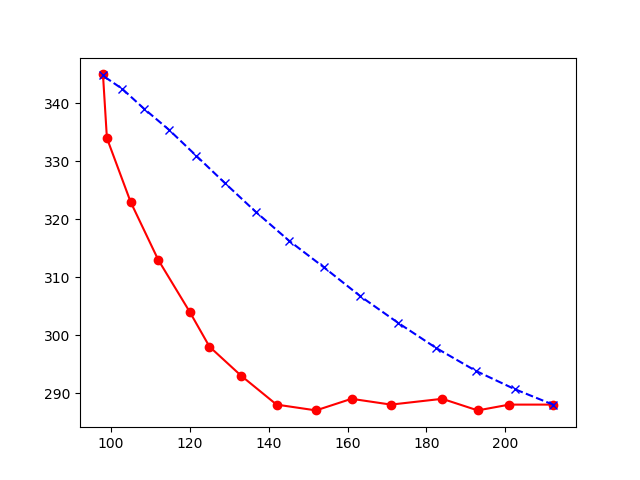

(13,)
(13,)


In [34]:
plt.figure()

print(np.asarray(true_paths).shape)
print(np.asarray(plan).shape)

true_x = []
true_y = []
pred_x = []
pred_y = []

for i in true_paths[0]:
    true_x.append(i[0])
    true_y.append(i[1])
    
for y in plan[0]:
    pred_x.append(y[0])
    pred_y.append(y[1])

plt.plot(true_x, true_y, color="red", linestyle='solid', marker='o')
plt.plot(pred_x, pred_y, color="blue", linestyle='dashed', marker='x')

plt.show()

In [35]:
plt.gcf().clear()
plt.close()

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [54]:
print(len(true_paths))
true_x = []
true_y = []
for a in range(len(true_paths)):
#     print(np.asarray(true_paths[a]).shape)
    true_x.append([])
    true_y.append([])
#     print("---------------")
    for i in range(len(true_paths[a])):
#         print(np.asarray(i).shape)
        true_x[a].append(true_paths[a][i][0])
        true_y[a].append(true_paths[a][i][1])
    true_x[a] = np.asarray(true_x[a])
    true_y[a] = np.asarray(true_y[a])

13


In [71]:
print(true_x[0])
print(true_x[2])

[ 211.99999979  200.99999989  192.99999948  183.99999994  171.00000012
  161.00000013  151.99999998  142.00000009  133.00000002  125.00000079
  120.0000008   112.00000081  105.00000038   99.00000035   98.00000066]
[ 269.99999975  262.99999962  247.99999908  241.00000037  237.00000089
  227.00000006  216.9999993   211.00000006  199.00000006  192.00000073
  183.00000077  175.0000009   168.00000009  160.99999991  151.99999998
  151.99999998  143.00000002  132.99999993  127.99999912]


<IPython.core.display.Javascript object>


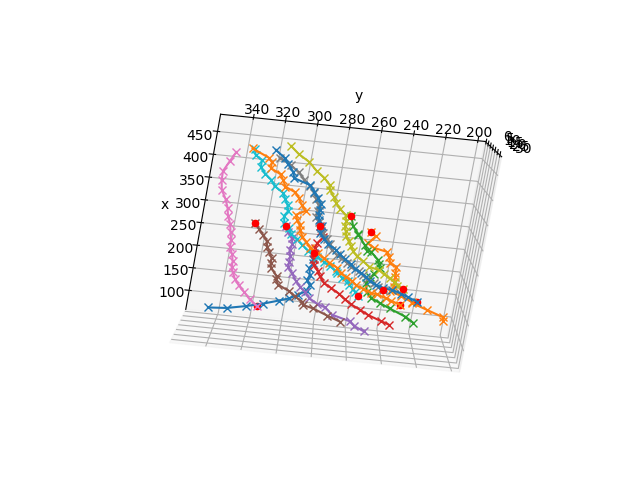

In [78]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
for i in range(1, len(true_x)):
    ax.plot(true_x[i], true_y[i], np.arange(len(true_paths[i])), marker = 'x')
    ax.scatter(*np.asarray([true_x[i][0], true_y[i][0], 0]), color = 'red')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [26]:
print([[int(i[y]) for y in range(3)] for i in plan[0]])

[[212, 287, 1], [202, 290, 1], [192, 293, 1], [182, 297, 1], [173, 301, 1], [163, 306, 1], [154, 311, 1], [145, 317, 1], [137, 322, 1], [129, 327, 1], [121, 331, 1], [115, 336, 1], [108, 339, 1], [102, 342, 1], [97, 344, 1]]
